In [16]:
#compute weights
import numpy as np
from AdaCapNet import *
import architectures
from copy import deepcopy
import torch
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score as auc

In [17]:
#plot weights
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import pandas as pd
import scipy
import scipy.cluster.hierarchy as sch
%matplotlib inline

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 0
generate_weights = True
weight_repository = "./weights/"
output_figure_path = "./figures/"
figure_name = "WeightCorrelation.pdf"

# Generate weights

## Load Boston Dataset

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import load_boston as lb
def prepare_dataset(X, y, train_size = 0.8, normalize_X = True, seed= False):
    kwargs = {}
    if seed or type(seed)== type(0):
        kwargs["random_state"] = seed
        np.random.seed(seed)
    if normalize_X: X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = tts(X, y, train_size = train_size, **kwargs)
    return X_train, X_test, y_train, y_test
def prepare_boston(train_size = 0.8, seed= 0, normalize_X = True, standardize_y = True):
    X,y = lb(return_X_y=True)
    if standardize_y: y = (y - y.mean())/y.std()
    X_train, X_test, y_train, y_test = prepare_dataset(X, y, train_size = train_size , seed=seed, normalize_X = normalize_X)
    return X_train, X_test, y_train, y_test
if generate_weights:
    X_train, X_test, y_train, y_test = prepare_boston(seed = seed, standardize_y = False)

## Define medium-wide NN architectures

In [20]:
import architectures
#using custom but not too wide architectures for GPU RAM constraints
#simple MLP with 3layers, 1024 neurons per layer
adacapnetmediumwide = {"lr_scheduler" : "OneCycleLR",
                "lr_scheduler_params" : {"max_lr":1e-3, "total_steps" : 500},
                "max_iter":500,
                "learning_rate":1e-3, #useless with OneCycleLR
                "hidden_nn" : architectures.DenseLayers,
                "hidden_params" :  {"width":1024,"depth":3, "device":device} 
                }

## Initial weights (figure not provided in the article)

In [22]:
if generate_weights:
    default_parameters = deepcopy(eval("adacapnetmediumwide"))
    default_parameters["hidden_params"]["n_features"] = X_train.shape[-1]
    default_parameters["lr_scheduler"] = False #Lr scheduler causes issues with 0 iterations runs.
    default_parameters["max_iter"] = 0
    reg = AdaCapNetRegressor(random_state = seed, **default_parameters)
    reg.fit(X_train,y_train)
    print("R2-score :",reg.score(X_test, y_test))
    initial_weights = reg.hidden_layers.model[4].weight.detach().cpu().numpy()
    np.save(weight_repository+"Initial_Weights", initial_weights)
    reg.delete_model_weights()  #else gpu memory leaks
    del reg

R2-score : -0.3581853752805757


## AdaCap

In [23]:
if generate_weights:
    default_parameters = deepcopy(eval("adacapnetmediumwide"))
    default_parameters["hidden_params"]["n_features"] = X_train.shape[-1]
    reg = AdaCapNetRegressor(random_state = seed, **default_parameters)
    reg.fit(X_train,y_train)
    print("R2-score :",reg.score(X_test, y_test))
    AdaCap_weights = reg.hidden_layers.model[4].weight.detach().cpu().numpy()
    np.save(weight_repository+"AdaCap_Weights", AdaCap_weights)
    reg.delete_model_weights()  #else gpu memory leaks
    del reg

R2-score : 0.8016157099003289


## Tikhonov

In [24]:
if generate_weights:
    default_parameters = deepcopy(eval("adacapnetmediumwide"))
    default_parameters["hidden_params"]["n_features"] = X_train.shape[-1]
    default_parameters["permutation_scale"] = False
    reg = AdaCapNetRegressor(random_state = seed, **default_parameters)
    reg.fit(X_train,y_train)
    print("R2-score :",reg.score(X_test, y_test))
    Tikhonov_weights = reg.hidden_layers.model[4].weight.detach().cpu().numpy()
    np.save(weight_repository+"Tikhonov_Weights", Tikhonov_weights)
    reg.delete_model_weights()  #else gpu memory leaks
    del reg

R2-score : 0.7926240092576978


## RegularNet

In [25]:
if generate_weights:
    default_parameters = deepcopy(eval("adacapnetmediumwide"))
    default_parameters["hidden_params"]["n_features"] = X_train.shape[-1]
    default_parameters["closeform_parameter_init"] = False
    default_parameters["hidden_params"].update({"dropout":0.1, "batch_norm":True, "output":1})
    reg = AdaCapNetRegressor(random_state = seed, **default_parameters)
    reg.fit(X_train,y_train)
    print("R2-score :",reg.score(X_test, y_test))
    Regular_weights = reg.hidden_layers.model[8].weight.detach().cpu().numpy()
    np.save(weight_repository+"Regular_Weights", Regular_weights)
    reg.delete_model_weights()  #else gpu memory leaks
    del reg

R2-score : 0.7558484454630232


## RegularNet + WeightDecay

In [26]:
if generate_weights:
    default_parameters = deepcopy(eval("adacapnetmediumwide"))
    default_parameters["hidden_params"]["n_features"] = X_train.shape[-1]
    default_parameters["closeform_parameter_init"] = False
    default_parameters["hidden_params"].update({"dropout":0.1, "batch_norm":True, "output":1})
    default_parameters["optimizer_params"] = {"weight_decay":1e-3}
    reg = AdaCapNetRegressor(random_state = seed, **default_parameters)
    reg.fit(X_train,y_train)
    print("R2-score :",reg.score(X_test, y_test))
    WeightDecay_weights = reg.hidden_layers.model[8].weight.detach().cpu().numpy()
    np.save(weight_repository+"WeightDecay_Weights", WeightDecay_weights)
    reg.delete_model_weights()  #else gpu memory leaks
    del reg

R2-score : 0.7450751164681401


# Plot Correlations

In [27]:
#perform two pass clustering on weights to reorder rows and columns (improve visualization)      
def two_pass_cluster_mat(df, cluster_th = 4):
    X = df.corr().values
    d = sch.distance.pdist(X)
    L = sch.linkage(d, method='complete')
    ind = sch.fcluster(L, 0.5*d.max(), 'distance')

    columns = [df.columns.tolist()[i] for i in list(np.argsort(ind))]
    df = df.reindex(columns, axis=1)

    unique, counts = np.unique(ind, return_counts=True)
    counts = dict(zip(unique, counts))

    i = 0
    j = 0
    columns = []
    for cluster_l1 in set(sorted(ind)):
        j += counts[cluster_l1]
        sub = df[df.columns.values[i:j]]
        if counts[cluster_l1]>cluster_th:        
            X = sub.corr().values
            d = sch.distance.pdist(X)
            L = sch.linkage(d, method='complete')
            ind = sch.fcluster(L, 0.5*d.max(), 'distance')
            col = [sub.columns.tolist()[i] for i in list((np.argsort(ind)))]
            sub = sub.reindex(col, axis=1)
        cols = sub.columns.tolist()
        columns.extend(cols)
        i = j
    df = df.reindex(columns, axis=1)
    return df
def compute_correlation(df, cluster_th = 4):
    clustered_df = two_pass_cluster_mat(df, cluster_th = cluster_th)
    corr = np.abs(clustered_df.corr())
    threshold = 0.5#scale diagonal to improve visualization
    corr_mat = corr.values - np.diag(np.diag(corr.values)-threshold)
    for col_index, col in enumerate(corr.columns):
        corr[col] = corr_mat[:, col_index]
    return corr

In [28]:
ordered_method_names = ["Regular","WeightDecay","Tikhonov","AdaCap"]
datas = {}
for method_name in ordered_method_names:
    datas[method_name] = np.load(weight_repository+method_name + "_Weights" + ".npy", 
                                                mmap_mode=None, 
                                                allow_pickle=False, 
                                                fix_imports=True, 
                                                encoding='ASCII')
pretty_labels = {key:key for key in method_names}
correlation_matrices = {}
for method_name in method_names:
    correlation_matrices[method_name] = compute_correlation(pd.DataFrame(datas[method_name]))

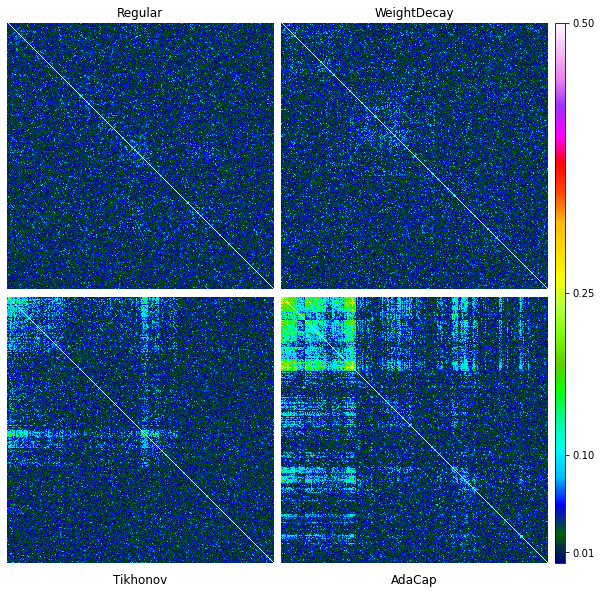

In [29]:
#https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html
size = 10
cmap = 'gist_ncar'
fig = plt.figure(figsize=(size, size))
grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.1,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                cbar_size = "2%"
                )
for i, method_name in enumerate(ordered_method_names):
    corr = correlation_matrices[method_name]
    cax = grid[i].matshow(corr, cmap=cmap)
    if i < 2:
        grid[i].set_title(method_name)
    if i>= 2:
        grid[i].set_title(method_name, y=-0.1)
    grid.cbar_axes[i].colorbar(cax, ticks=[0.,0.01,0.1,0.25,0.5, 1])
    grid[i].axis('off')
plt.savefig(output_figure_path + figure_name, dpi='figure', format="pdf",bbox_inches='tight')